In [116]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from imblearn.over_sampling import SMOTE

In [64]:
# Load dataset
df = pd.read_csv("Cell Counts.csv")

In [66]:
df.head()

,patient,basophil,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet,target
0,RHX,0.052314,0.000000,0.022133,0.573441,0.038229,0.281690,0.014085,0.018109,RUNX1_RUNX1T1
1,BHG,0.014085,0.002012,0.012072,0.334004,0.018109,0.597586,0.018109,0.004024,RUNX1_RUNX1T1
2,HVE,0.016835,0.000000,0.141414,0.272727,0.080808,0.464646,0.000000,0.023569,RUNX1_RUNX1T1
3,ZJJ,0.094758,0.000000,0.006048,0.562500,0.004032,0.306452,0.018145,0.008065,RUNX1_RUNX1T1
4,ZVX,0.040900,0.000000,0.026585,0.382413,0.083845,0.429448,0.004090,0.032720,RUNX1_RUNX1T1


In [68]:
df.value_counts('target', ascending=False)

target
control          60
CBFB_MYH11       37
NPM1             36
RUNX1_RUNX1T1    32
PML_RARA         24
Name: count, dtype: int64

In [70]:
df.drop(columns=['patient'], inplace=True) # Not a feature

In [72]:
# Encode target variable as categorical
label_encoder = LabelEncoder()
df["target"] = label_encoder.fit_transform(df["target"])

In [74]:
df.sample(5)

,basophil,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet,target
159,0.020833,0.000000,0.047917,0.795833,0.008333,0.091667,0.000000,0.035417,1
161,0.010225,0.000000,0.024540,0.257669,0.114519,0.574642,0.002045,0.016360,1
180,0.016097,0.000000,0.038229,0.317907,0.239437,0.307847,0.004024,0.076459,2
126,0.030242,0.002016,0.060484,0.385081,0.006048,0.510081,0.000000,0.006048,0
80,0.479508,0.000000,0.057377,0.299180,0.000000,0.127049,0.036885,0.000000,4


In [76]:
# Split into features (X) and labels (y)
X = df.drop(columns=["target"])
y = df["target"]

In [171]:
# Split into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [173]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

#### Hyperparameter Tuning

In [122]:
param_grid = {
    "max_depth": [4, 6, 8, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "n_estimators": [100, 300, 500, 1000],
    "colsample_bytree": [0.7, 0.8, 1.0],
    "subsample": [0.7, 0.8, 1.0]
}

In [124]:
grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(
        objective="multi:softmax", 
        num_class=len(y.unique()), 
        eval_metric="mlogloss",
        random_state=42
    ),
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,
    verbose=2,
    n_jobs=-1
)

In [128]:
grid_search.fit(X_train_resampled, y_train_resampled)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_class=5,
                                     num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'max_depth': [4, 6, 8, 10],
                         'n_estimators': [100, 300, 500, 1000],
                         'subsample': [0.7, 0.8, 1.0]},
             scoring='accuracy', verbose=2)

In [129]:
print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 1000, 'subsample': 0.7}


In [132]:
# Initialize XGBoost model
xgb_model = xgb.XGBClassifier(
    objective="multi:softmax",  # Multiclass classification
    num_class=len(y.unique()),  # Number of classes
    eval_metric="mlogloss",  # Log loss for multi-class
    max_depth=10, 
    learning_rate=0.2, 
    n_estimators=1000,
    colsample_bytree=1.0,
    subsample=0.7,
    random_state=42
)

In [134]:
# Train the model
xgb_model.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_class=5, num_parallel_tree=None, ...)

In [135]:
# Predict on test set
y_pred = xgb_model.predict(X_test)

In [138]:
# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.3421


#### Understanding Feature Importance

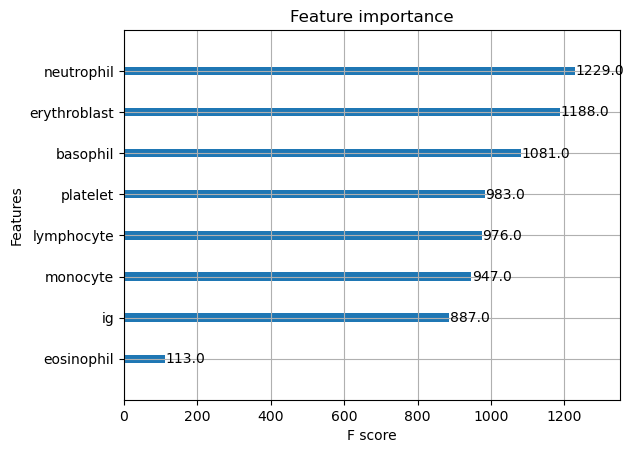

In [141]:
xgb.plot_importance(xgb_model)
plt.show()

### Light GB Model

In [195]:
import lightgbm as lgb
import optuna
from lightgbm import early_stopping

In [150]:
lgb_model = lgb.LGBMClassifier(
    boosting_type="gbdt",
    objective="multiclass",
    num_class=len(y.unique()),
    max_depth=10,
    learning_rate=0.05,
    n_estimators=1000,
    colsample_bytree=0.9,
    subsample=0.9,
    random_state=42
)

In [ ]:
lgb_model.fit(X_train_resampled, y_train_resampled)

In [158]:
y_pred = lgb_model.predict(X_test)

In [160]:
accuracy = accuracy_score(y_test, y_pred)
print(f"LightGBM Accuracy: {accuracy:.4f}")

LightGBM Accuracy: 0.3947


#### Hyperparameter tuning using Optuna

In [187]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [318]:
# Define objective function for Optuna
def objective(trial):
    params = {
        "objective": "multiclass",
        "num_class": len(set(y_train)),
        "metric": "multi_logloss",
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 150, step=10),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 100, step=10),
        "subsample": trial.suggest_uniform("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-3, 10.0),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=100),
    }
    
    model = lgb.LGBMClassifier(**params, random_state=42)

    # Fit model with early stopping
    model.fit(
        X_train_resampled, y_train_resampled, 
        eval_set=[(X_val, y_val)], 
        eval_metric="multi_logloss", 
        callbacks=[early_stopping(stopping_rounds=50)]
    )
    
    preds = model.predict(X_val)
    return accuracy_score(y_val, preds)

In [ ]:
# Run Optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

In [321]:
# Best hyperparameters
print("Best hyperparameters:", study.best_params)

Best hyperparameters: {'learning_rate': 0.2692189603377494, 'num_leaves': 30, 'max_depth': 13, 'min_child_samples': 100, 'subsample': 0.6324145041723641, 'colsample_bytree': 0.7339706108953263, 'reg_alpha': 0.011408887238915533, 'reg_lambda': 3.8039067302068412, 'n_estimators': 1000}


In [ ]:
# Train final model with best params
best_params = study.best_params
final_model = lgb.LGBMClassifier(**best_params, random_state=42)
final_model.fit(X_train_resampled, y_train_resampled)

In [338]:
# Evaluate final model
y_pred = final_model.predict(X_val)
final_accuracy = accuracy_score(y_val, y_pred)
print(f"Final Accuracy: {final_accuracy:.4f}")

Final Accuracy: 0.3684


#### Other metrics

In [294]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [296]:
classes = label_encoder.classes_

In [298]:
print(classes)

['CBFB_MYH11' 'NPM1' 'PML_RARA' 'RUNX1_RUNX1T1' 'control']


In [300]:
# Classification Report (Precision, Recall, F1-score)
print(classification_report(y_val, y_pred, target_names=classes))

               precision    recall  f1-score   support

   CBFB_MYH11       0.22      0.25      0.24         8
         NPM1       0.18      0.29      0.22         7
     PML_RARA       0.75      0.60      0.67         5
RUNX1_RUNX1T1       0.00      0.00      0.00         6
      control       1.00      0.75      0.86        12

     accuracy                           0.42        38
    macro avg       0.43      0.38      0.40        38
 weighted avg       0.49      0.42      0.45        38



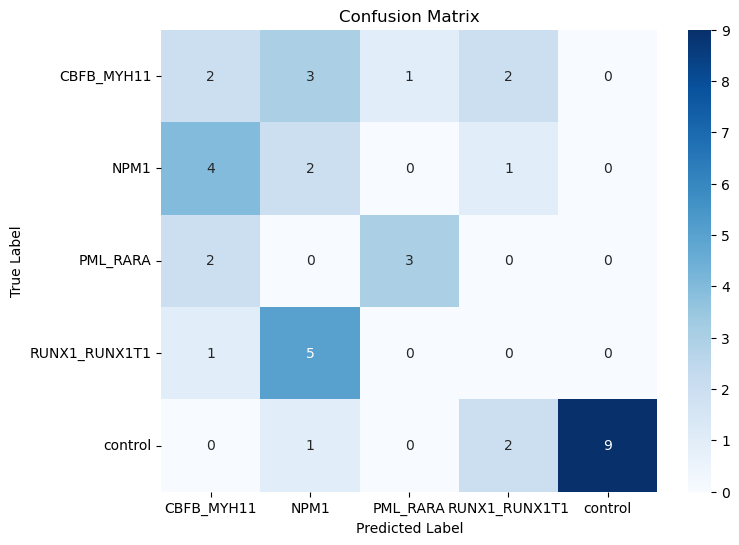

In [302]:
# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

### Using Multi-Layer Perceptron (MLP) classifier

In [432]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import numpy as np

In [434]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [436]:
# Normalize the data (important for deep learning models)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [438]:
# Convert labels to categorical (One-Hot Encoding)
num_classes = len(np.unique(y))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [440]:
# Build the MLP model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),  # Helps stabilize training
    Dropout(0.3),  # Prevents overfitting
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')  # Softmax for multi-class classification
])

In [442]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',  # Suitable for multi-class problems
              metrics=['accuracy'])

In [444]:
# Train the model
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=50, 
                    batch_size=32, 
                    verbose=1)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.1440 - loss: 2.6587 - val_accuracy: 0.1316 - val_loss: 1.6551
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2137 - loss: 2.3930 - val_accuracy: 0.1579 - val_loss: 1.6363
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1599 - loss: 2.0658 - val_accuracy: 0.1316 - val_loss: 1.6218
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.1345 - loss: 2.0476 - val_accuracy: 0.1579 - val_loss: 1.6088
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2458 - loss: 1.7691 - val_accuracy: 0.1053 - val_loss: 1.5956
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2999 - loss: 1.6289 - val_accuracy: 0.1316 - val_loss: 1.5856
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2773 - loss: 1.5646 - val_accuracy: 0.1316 - val_loss: 1.5756
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3054 - loss: 1.5280 - val_accuracy: 0.1579 - val_loss: 1.5616

In [ ]:
# Get predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

In [446]:
# Classification Report
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.44      0.50      0.47         8
           1       0.27      0.57      0.36         7
           2       0.50      0.20      0.29         5
           3       0.00      0.00      0.00         6
           4       0.83      0.83      0.83        12

    accuracy                           0.50        38
   macro avg       0.41      0.42      0.39        38
weighted avg       0.47      0.50      0.47        38



In [452]:
# Save model
model.save('multi_class_mlp_classifier.h5')
model.save('multi_class_mlp_classifier.keras')

#### Improving MLP

In [366]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import numpy as np
import optuna

In [466]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [468]:
# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [470]:
# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [472]:
# Convert labels to categorical (One-Hot Encoding)
num_classes = len(np.unique(y))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [474]:
# Build a deeper MLP model with more layers and regularization
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')  # Softmax for multi-class classification
])

In [476]:
# Compile the model with a lower learning rate to prevent overfitting
model.compile(optimizer=Adam(learning_rate=0.0005),  # Reduced LR
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [478]:
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=100,  # Increased for better learning
                    batch_size=32, 
                    verbose=1)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.1671 - loss: 2.2520 - val_accuracy: 0.2105 - val_loss: 1.6397
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2623 - loss: 2.0449 - val_accuracy: 0.2105 - val_loss: 1.6162
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1976 - loss: 1.9671 - val_accuracy: 0.2368 - val_loss: 1.6016
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2577 - loss: 1.7541 - val_accuracy: 0.2895 - val_loss: 1.5964
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3042 - loss: 1.6601 - val_accuracy: 0.2368 - val_loss: 1.5895
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3866 - loss: 1.6061 - val_accuracy: 0.2632 - val_loss: 1.5824
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3670 - loss: 1.5148 - val_accuracy: 0.2368 - val_loss: 1.5743
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3949 - loss: 1.5012 - val_accuracy: 0.2368 - val_loss

In [479]:
# Get predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification Report
print(classification_report(y_true, y_pred_classes))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
              precision    recall  f1-score   support

           0       0.43      0.38      0.40         8
           1       0.00      0.00      0.00         7
           2       0.43      0.60      0.50         5
           3       0.25      0.33      0.29         6
           4       0.90      0.75      0.82        12

    accuracy                           0.45        38
   macro avg       0.40      0.41      0.40        38
weighted avg       0.47      0.45      0.45        38



In [482]:
def objective(trial):
    num_units1 = trial.suggest_int("num_units1", 128, 512)
    num_units2 = trial.suggest_int("num_units2", 64, 256)
    dropout_rate1 = trial.suggest_float("dropout_rate1", 0.2, 0.5)
    dropout_rate2 = trial.suggest_float("dropout_rate2", 0.2, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3)
    
    # Build model
    model = Sequential([
        Dense(num_units1, activation='relu', input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(dropout_rate1),
        Dense(num_units2, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate2),
        Dense(num_classes, activation='softmax')
    ])
    
    # Compile model
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    # Train model
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
    
    # Evaluate on validation data
    _, accuracy = model.evaluate(X_test, y_test, verbose=0)
    return accuracy

In [ ]:
# Run Optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

In [485]:
print("Best hyperparameters:", study.best_params)

Best hyperparameters: {'num_units1': 476, 'num_units2': 72, 'dropout_rate1': 0.33685764904429827, 'dropout_rate2': 0.3423963509663033, 'learning_rate': 0.00033963913703839076}


In [486]:
# Retrieve best hyperparameters
best_params = study.best_params
num_units1 = best_params["num_units1"]
num_units2 = best_params["num_units2"]
dropout_rate1 = best_params["dropout_rate1"]
dropout_rate2 = best_params["dropout_rate2"]
learning_rate = best_params["learning_rate"]

In [487]:
# Build the final optimized model
final_dmodel = Sequential([
    Dense(num_units1, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(dropout_rate1),
    Dense(num_units2, activation='relu'),
    BatchNormalization(),
    Dropout(dropout_rate2),
    Dense(num_classes, activation='softmax')
])

In [488]:
# Compile the model with the optimized learning rate
final_dmodel.compile(optimizer=Adam(learning_rate=learning_rate), 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'])

In [489]:
# Train the model with optimized parameters
final_dmodel.fit(X_train, y_train, 
                validation_data=(X_test, y_test), 
                epochs=100,  
                batch_size=32, 
                verbose=1)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.2364 - loss: 2.4906 - val_accuracy: 0.2368 - val_loss: 1.5786
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2965 - loss: 2.0712 - val_accuracy: 0.3158 - val_loss: 1.5395
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3417 - loss: 1.6984 - val_accuracy: 0.3421 - val_loss: 1.5167
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3583 - loss: 1.6905 - val_accuracy: 0.3158 - val_loss: 1.5009
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4049 - loss: 1.6414 - val_accuracy: 0.3158 - val_loss: 1.4936
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4082 - loss: 1.5905 - val_accuracy: 0.3421 - val_loss: 1.4920
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5062 - loss: 1.3078 - val_accuracy: 0.3684 - val_loss: 1.4964
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4902 - loss: 1.3724 - val_accuracy: 0.3684 - val_loss:

In [496]:
# Get predictions
y_pred = final_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test, axis=1)

In [498]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.20      0.12      0.15         8
           1       0.20      0.14      0.17         7
           2       0.11      0.20      0.14         5
           3       0.00      0.00      0.00         6
           4       0.58      0.92      0.71        12

    accuracy                           0.37        38
   macro avg       0.22      0.28      0.23        38
weighted avg       0.28      0.37      0.31        38

